------------------------------
#### Objective : understand RNN
- Input data (embeddings)
- forward propagation (time steps)
- compute the memory vector/ hidden states at each time step
--------------------------------

**outline**

In sequence modeling with Recurrent Neural Networks (RNNs), the process consists of three main steps. 
- `Firstly`, the input data is converted into embeddings, representing continuous vector representations of the sequential input.
- `Secondly`, the RNN undergoes forward propagation through `time steps`, updating `hidden states` by `combining` input embeddings and previous hidden states. This recursive process allows the model to capture patterns within the sequence.
- `Lastly`, the computation of memory vectors or hidden states at each time step is essential for retaining relevant information from the input sequence, serving as memory for tasks like sequence prediction. 

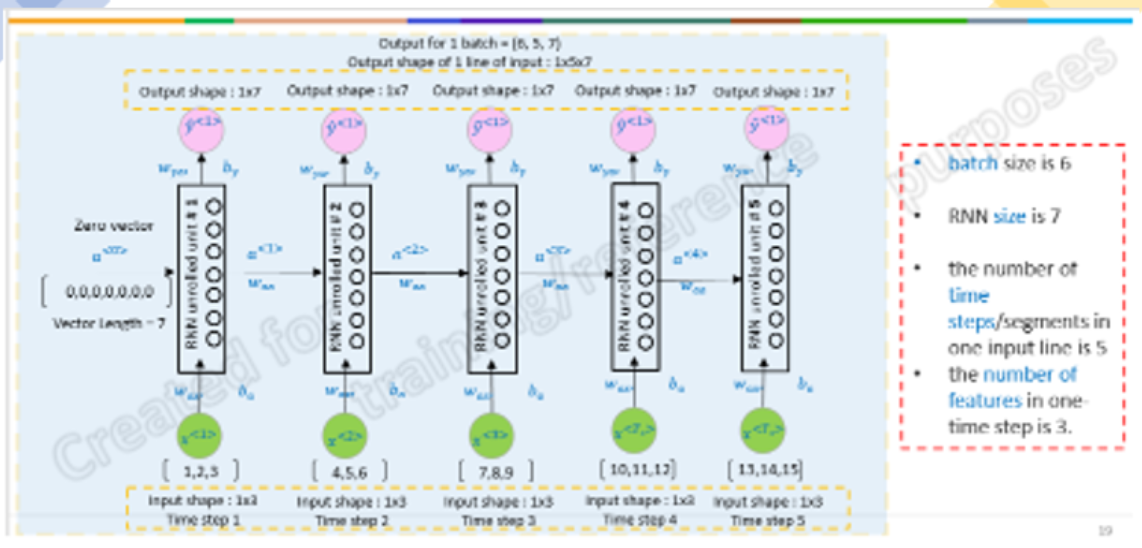

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, edgeitems=10)

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)

#### How is Data prepared for RNN

In [3]:
# Number of samples for each class
num_samples = 10

In [4]:
# Dummy embeddings for AI class
ai_embeddings = np.random.rand(num_samples, 2) * 2  # Random values between 0 and 2

In [5]:
ai_embeddings

array([[0.7491, 1.9014],
       [1.464 , 1.1973],
       [0.312 , 0.312 ],
       [0.1162, 1.7324],
       [1.2022, 1.4161],
       [0.0412, 1.9398],
       [1.6649, 0.4247],
       [0.3636, 0.3668],
       [0.6085, 1.0495],
       [0.8639, 0.5825]])

In [6]:
# AI-related words
ai_words = ["Artificial", 
            "Intelligence",
            "Machine", 
            "Learning", 
            "Algorithm", 
            "Neural", 
            "Network", 
            "Automation", 
            "Robotics", 
            "Cognitive"]

In [7]:
# Display assigned words and embeddings for AI
for word, embedding in zip(ai_words, ai_embeddings):
    print(f"{word}: {embedding}")

Artificial: [0.7491 1.9014]
Intelligence: [1.464  1.1973]
Machine: [0.312 0.312]
Learning: [0.1162 1.7324]
Algorithm: [1.2022 1.4161]
Neural: [0.0412 1.9398]
Network: [1.6649 0.4247]
Automation: [0.3636 0.3668]
Robotics: [0.6085 1.0495]
Cognitive: [0.8639 0.5825]


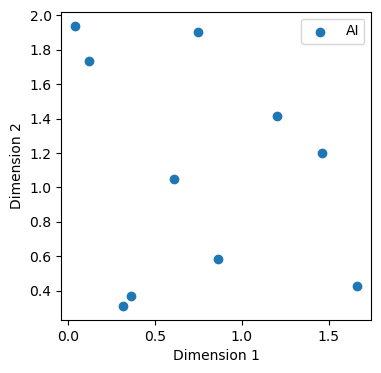

In [8]:
# Scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(ai_embeddings[:, 0], ai_embeddings[:, 1], label='AI', marker='o')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend();

#### make a sample data (point) with number of sequences =2 

In [10]:
# Provided data point
input_data = np.array([[[1.46398788, 1.19731697], 
                        [0.31203728, 0.31198904]]])

In [11]:
# define parameters
input_dim   = 2
output_dim  = 2

# Initialize memory vector
hidden_size   = 7

In [12]:
# initialize memory vector
memory_vector = np.zeros((1, hidden_size))
memory_vector

array([[0., 0., 0., 0., 0., 0., 0.]])

**weight (input - hidden)**

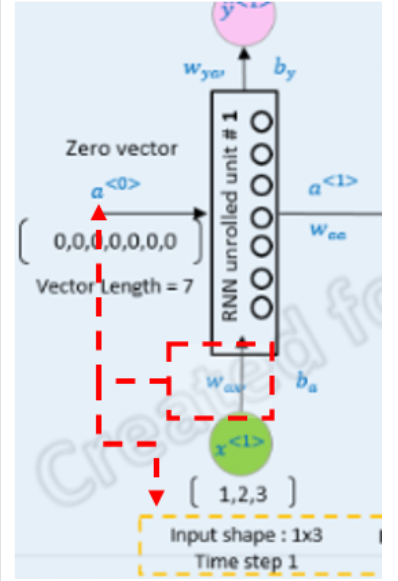

In [13]:
weight_xh = np.random.randn(input_dim,   hidden_size ) # Weight for input
weight_xh

array([[-1.0128,  0.3142, -0.908 , -1.4123,  1.4656, -0.2258,  0.0675],
       [-1.4247, -0.5444,  0.1109, -1.151 ,  0.3757, -0.6006, -0.2917]])

**bias term for the hidden neurons**

In [14]:
bias_h = np.random.randn(1, hidden_size)               # Bias term
bias_h

array([[-0.6017,  1.8523, -0.0135, -1.0577,  0.8225, -1.2208,  0.2089]])

**weights (hidden to hidden)**

In [15]:
weight_hh = np.random.randn(hidden_size, hidden_size)  # Weight for hidden state
weight_hh

array([[-1.9597, -1.3282,  0.1969,  0.7385,  0.1714, -0.1156, -0.3011],
       [-1.4785, -0.7198, -0.4606,  1.0571,  0.3436, -1.763 ,  0.3241],
       [-0.3851, -0.6769,  0.6117,  1.031 ,  0.9313, -0.8392, -0.3092],
       [ 0.3313,  0.9755, -0.4792, -0.1857, -1.1063, -1.1962,  0.8125],
       [ 1.3562, -0.072 ,  1.0035,  0.3616, -0.6451,  0.3614,  1.538 ],
       [-0.0358,  1.5646, -2.6197,  0.8219,  0.087 , -0.299 ,  0.0918],
       [-1.9876, -0.2197,  0.3571,  1.4779, -0.5183, -0.8085, -0.5018]])

In [16]:
# Assuming b_y is the bias term for the output layer
b_y = np.random.randn(1, output_dim)                   # Bias term
b_y

array([[0.9154, 0.3288]])

In [17]:
# Weight for connection from hidden to output
weight_yh  = np.random.randn(hidden_size, output_dim)  
weight_yh

array([[-0.5298,  0.5133],
       [ 0.0971,  0.9686],
       [-0.7021, -0.3277],
       [-0.3921, -1.4635],
       [ 0.2961,  0.2611],
       [ 0.0051, -0.2346],
       [-1.4154, -0.4206]])

#### Perform one pass through the RNN

In [18]:
# define some placeholders 
# to save computations from each of the timesteps
hidden_states = []  # memory vector
logits        = []  # output
softmax_probs = []  # predictions

#### time step 1

$$ \large 𝑎^{<𝑡>} = 𝑔(w_{𝑎𝑎} . 𝑎^{<𝑡−1>} + w_{𝑎𝑥} . 𝑥^{<𝑡>} + 𝑏_𝑎 )$$

In [19]:
input_data

array([[[1.464 , 1.1973],
        [0.312 , 0.312 ]]])

In [20]:
input_data[:, 0, :]

array([[1.464 , 1.1973]])

In [21]:
# Time step 1
x_t = input_data[:, 0, :]                         # Input at time step 1

h_t = np.tanh(np.dot(memory_vector, weight_hh) + 
              np.dot(x_t, weight_xh)           + 
              bias_h)                             # RNN calculation

memory_vector = h_t               # Update memory vector
hidden_states.append(h_t.copy())  # Use copy to avoid reference

In [22]:
# Display the results, same as memory vector
print(f"hidden state at : time Step 1: {h_t}")

hidden state at : time Step 1: [[-0.999   0.9303 -0.8367 -0.9998  0.9979 -0.9789 -0.0415]]


In [23]:
# all hidden states
hidden_states

[array([[-0.999 ,  0.9303, -0.8367, -0.9998,  0.9979, -0.9789, -0.0415]])]

$$ \large \operatorname{logit}_t=W_{y a} \cdot a_t+b_y $$

In [24]:
# Compute logits and softmax
logit_t   = np.dot(h_t, weight_yh) + b_y                 # Assuming weight_yh.T is the transpose of weight_yh
softmax_t = np.exp(logit_t) / np.sum(np.exp(logit_t), axis=-1, keepdims=True)

In [25]:
logit_t

array([[2.8636, 2.962 ]])

In [26]:
softmax_t

array([[0.4754, 0.5246]])

#### time step 2

$$ \large 𝑎^{<𝑡>} = 𝑔(w_{𝑎𝑎} . 𝑎^{<𝑡−1>} + w_{𝑎𝑥} . 𝑥^{<𝑡>} + 𝑏_𝑎 )$$

In [27]:
# Time step 2
x_t = input_data[:, 1, :]                             # Input at time step 2

h_t = np.tanh(np.dot(memory_vector, weight_hh) + 
              np.dot(x_t, weight_xh) + 
              bias_h)                                 # RNN calculation

memory_vector = h_t  # Update memory vector
hidden_states.append(h_t.copy())                      # Use copy to avoid reference

In [28]:
# Display the results, same as memory vector
print(f"hidden state at : time Step 2: {h_t}")

hidden state at : time Step 2: [[ 0.5927  0.409   0.9897 -0.9925  0.8227 -0.3955  0.9293]]


In [29]:
# all hidden states
hidden_states

[array([[-0.999 ,  0.9303, -0.8367, -0.9998,  0.9979, -0.9789, -0.0415]]),
 array([[ 0.5927,  0.409 ,  0.9897, -0.9925,  0.8227, -0.3955,  0.9293]])]